In [1]:
from segmentator import Segmentator
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import torch

/work3/s183920/02514-DLCI/DLCI-venv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/work3/s183920/02514-DLCI/DLCI-venv/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [80]:
model = "deepcomputer/Segmentation/e9rw16i0_model:latest" # UNet drivve
# model = "deepcomputer/Segmentation/1ubcjyk2_model:v9" # Baseline drive
# model = "deepcomputer/Segmentation/nhw5vooa_model:v5" # baseline lesion
# model = "deepcomputer/Segmentation/5xacfcuq_model:v16" # unet lesion

model_type = "UNet"
segm = Segmentator(use_wandb=False, dataset = "DRIVE", num_epochs = 3, model = model_type)
segm.load_model("wandb:" + model)

from dataloader import DRIVE_data, Lesion_Data
data = DRIVE_data()
# data = Lesion_Data()
[data.image_paths[i] for i in segm.testset.indices]

Using device: cpu
Loading dataset: DRIVE
Loaded 13 training images
Loaded 4 test images
Loaded 3 validation images
Loading model from wandb:deepcomputer/Segmentation/e9rw16i0_model:latest


wandb: Downloading large artifact e9rw16i0_model:latest, 60.51MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.2


['/dtu/datasets1/02514/DRIVE/training/images/31_training.tif',
 '/dtu/datasets1/02514/DRIVE/training/images/36_training.tif',
 '/dtu/datasets1/02514/DRIVE/training/images/24_training.tif',
 '/dtu/datasets1/02514/DRIVE/training/images/27_training.tif']

In [47]:
segm.test()

(tensor(8.7303),
 {'dice_overlap': tensor(0.2899),
  'IoU': tensor(0.8648),
  'accuracy': tensor(0.9497),
  'sensitivity': tensor(0.8826),
  'specificity': tensor(0.9868)})

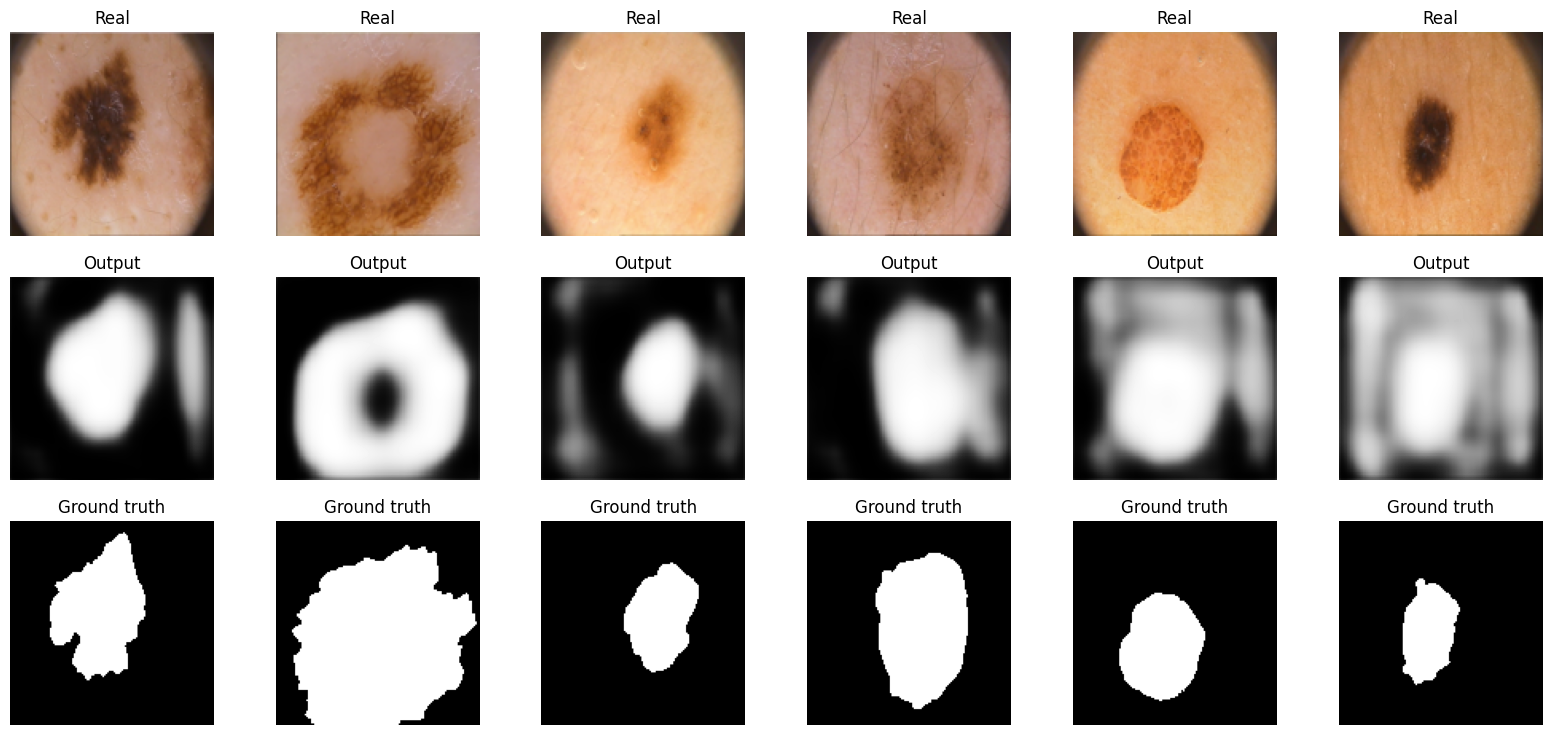

In [74]:
segm.test_images(validation=False)

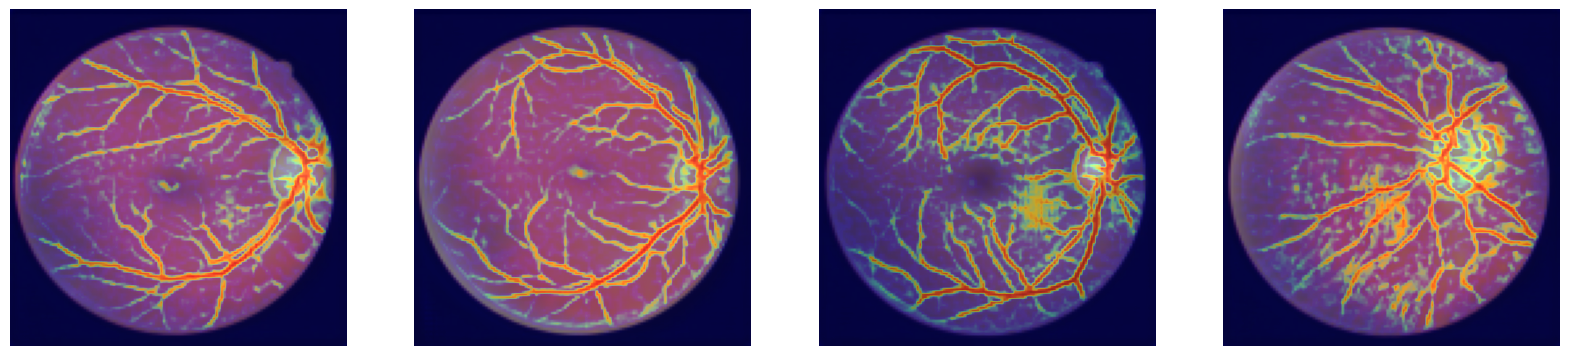

In [81]:
from tools import inverse_normalize

X_test, Y_test = next(iter(segm.test_loader))

# show intermediate results
segm.model.eval()  # testing mode
Y_hat = segm.model(X_test.to(segm.device)).detach().cpu()

X_test = inverse_normalize(X_test, segm.config["dataset"])

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
# for k in range(3, -1, -1):
for k in range(4):
    # show input image
    ax = axes[3-k]
    ax.imshow(np.rollaxis(X_test[k].numpy(), 0, 3), cmap='gray')
    
    # add mask prediction
    ax.imshow(Y_hat[k, 0], cmap='jet', alpha=0.4 if segm.config['dataset'] == "DRIVE" else 0.2)
    ax.set_axis_off()
    
    # ax.set_title('Real')
    # ax.set_axis_off()

    # # show mask prediction
    # ax = axes[1, k]
    # ax.imshow(Y_hat[k, 0], cmap='gray')
    # ax.set_title('Output')
    # ax.set_axis_off()
    
    # # show ground truth mask
    # ax = axes[2, k]
    # ax.imshow(Y_test[k, 0], cmap='gray')
    # ax.set_title('Ground truth')
    # ax.set_axis_off()

import os
os.makedirs("results", exist_ok=True)
plt.savefig(f"results/{model_type}_{segm.config['dataset']}.png")

# Get normalisation

In [10]:
from tqdm import tqdm
mean = np.zeros(3)
std = np.zeros(3)

train_subset = segm.trainset.dataset

for i in tqdm(range(len(train_subset))):
    mean += np.array(train_subset[i][0]).mean(axis=(1,2))
    std += np.array(train_subset[i][0]).std(axis=(1,2))

mean /= len(train_subset)

std /= len(train_subset)

print(mean, std)

100%|██████████| 20/20 [00:00<00:00, 25.55it/s]

[0.49740665 0.27065086 0.16243291] [0.32961248 0.17564391 0.09661924]


In [9]:
segm.testset.indices

[10, 15, 3, 6]

IndexError: index 3 is out of bounds for dimension 0 with size 3

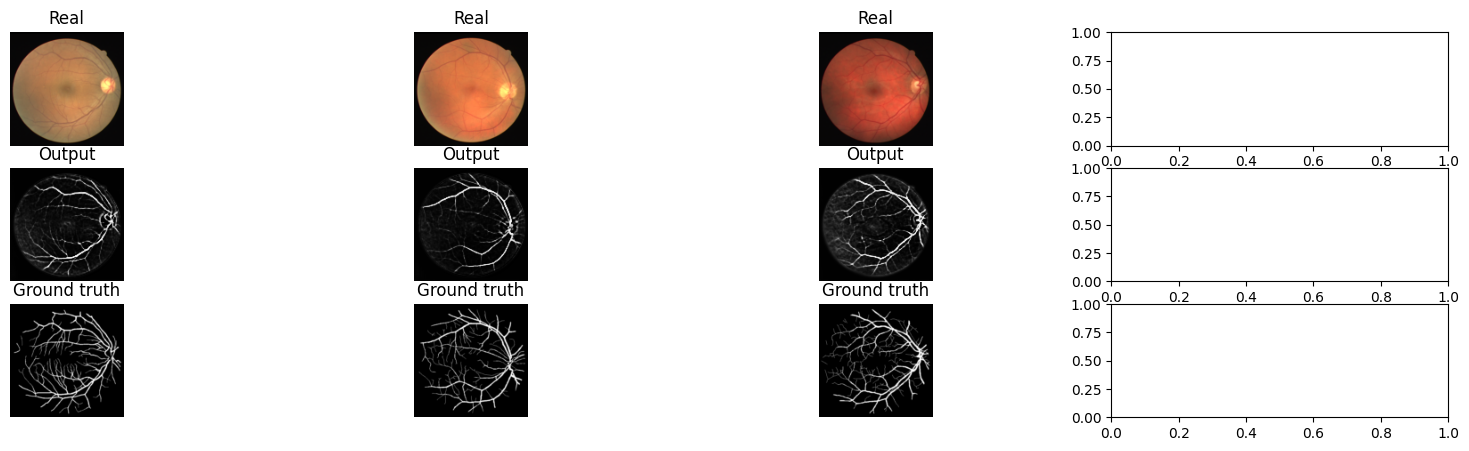

(array([1.3339e+04, 7.0000e+00, 7.0000e+00, 5.0000e+00, 4.0000e+00,
        2.0000e+00, 2.0000e+00, 2.0000e+00, 5.0000e+00, 3.0110e+03]),
 array([0.5       , 0.52310586, 0.54621172, 0.56931758, 0.59242344,
        0.6155293 , 0.63863516, 0.66174102, 0.68484688, 0.70795274,
        0.7310586 ]),
 <BarContainer object of 10 artists>)

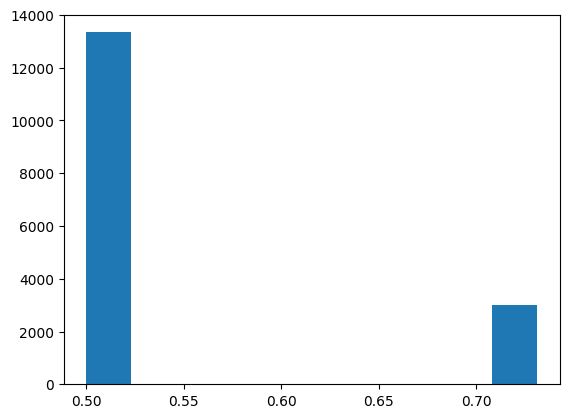

In [8]:
plt.hist(Y_hat[0].flatten())

Using device: cpu
Loading dataset: Lesion
Loaded 128 training images
Loaded 40 test images
Loaded 32 validation images


/work3/s183920/02514-DLCI/DLCI-venv/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)


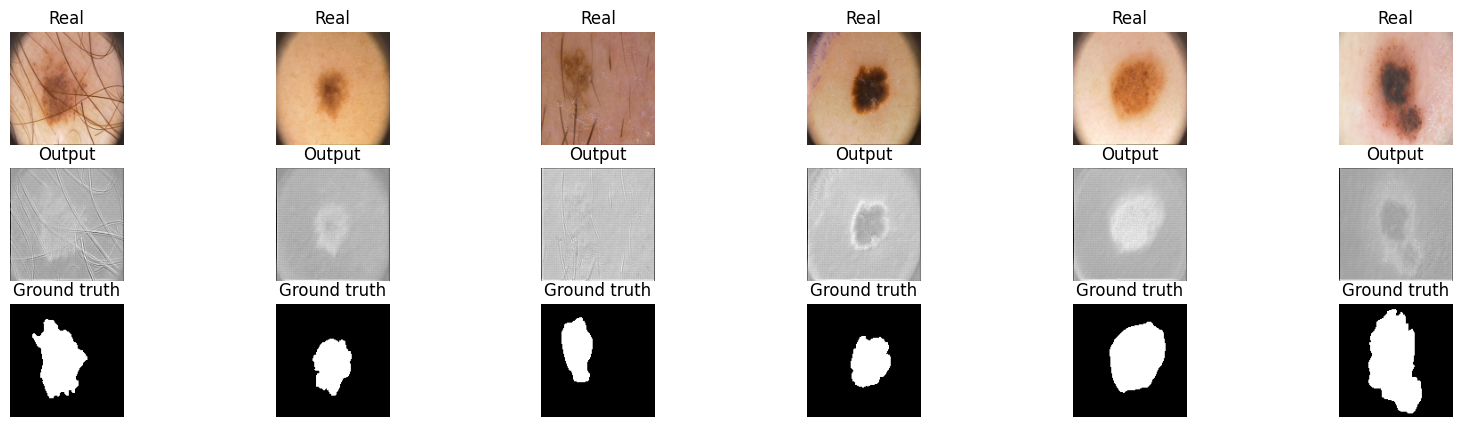

In [12]:
segm = Segmentator(use_wandb=False, dataset = "Lesion", num_epochs = 3)
segm.set_seed(42)

X_test, Y_test = next(iter(segm.val_loader))

# show intermediate results
segm.model.eval()  # testing mode
Y_hat = F.sigmoid(segm.model(X_test.to(segm.device))).detach().cpu()



fig, axes = plt.subplots(3, 6, figsize=(20, 5))
for k in range(6):
    
    # show input image
    ax = axes[0, k]
    print(X_test[k].numpy().shape)
    ax.imshow(np.rollaxis(X_test[k].numpy(), 0, 3), cmap='gray')
    ax.set_title('Real')
    ax.set_axis_off()

    # show mask prediction
    ax = axes[1, k]
    ax.imshow(Y_hat[k, 0], cmap='gray')
    ax.set_title('Output')
    ax.set_axis_off()
    
    # show ground truth mask
    ax = axes[2, k]
    ax.imshow(Y_test[k, 0], cmap='gray')
    ax.set_title('Ground truth')
    ax.set_axis_off()

In [ ]:
X_test, Y_test = next(iter(segm.val_loader))

# show intermediate results
segm.model.eval()  # testing mode
Y_hat = F.sigmoid(segm.model(X_test.to(segm.device))).detach().cpu()



fig, axes = plt.subplots(3, 6, figsize=(20, 5))
for k in range(6):
    
    # show input image
    ax = axes[0, k]
    print(X_test[k].numpy().shape)
    ax.imshow(np.rollaxis(X_test[k].numpy(), 0, 3), cmap='gray')
    ax.set_title('Real')
    ax.set_axis_off()

    # show mask prediction
    ax = axes[1, k]
    ax.imshow(Y_hat[k, 0], cmap='gray')
    ax.set_title('Output')
    ax.set_axis_off()
    
    # show ground truth mask
    ax = axes[2, k]
    ax.imshow(Y_test[k, 0], cmap='gray')
    ax.set_title('Ground truth')
    ax.set_axis_off()

In [9]:
segm.val_loader.dataset.__getitem__(0)

(tensor([[[0.1922, 0.1922, 0.2039,  ..., 0.1882, 0.2000, 0.6784],
          [0.1882, 0.1922, 0.2000,  ..., 0.1843, 0.2039, 0.6784],
          [0.1961, 0.2039, 0.2196,  ..., 0.2039, 0.2078, 0.6824],
          ...,
          [0.2314, 0.2353, 0.2275,  ..., 0.2157, 0.2314, 0.6902],
          [0.2392, 0.2431, 0.2392,  ..., 0.2235, 0.2392, 0.6941],
          [0.6980, 0.7020, 0.7020,  ..., 0.6902, 0.6980, 0.8784]],
 
         [[0.1804, 0.1804, 0.1882,  ..., 0.1843, 0.1882, 0.6745],
          [0.1843, 0.1882, 0.1922,  ..., 0.1882, 0.1922, 0.6745],
          [0.1843, 0.1843, 0.1922,  ..., 0.1843, 0.1922, 0.6745],
          ...,
          [0.2039, 0.1961, 0.1922,  ..., 0.1843, 0.1961, 0.6824],
          [0.2157, 0.2118, 0.2039,  ..., 0.1961, 0.2078, 0.6863],
          [0.6902, 0.6863, 0.6863,  ..., 0.6824, 0.6902, 0.8745]],
 
         [[0.1961, 0.2039, 0.2039,  ..., 0.1882, 0.2157, 0.6863],
          [0.1961, 0.2118, 0.2157,  ..., 0.1961, 0.2118, 0.6863],
          [0.1961, 0.2039, 0.2157,  ...,

In [33]:
print(f"{np.random.rand():.3f}")

0.183
